Dowloading the Pix3D dataset from their URL. Dataset will be stored in the this session's memory. The whole dowload should take about 2 minutes, depends on speed of internet connection.

In [ ]:
!wget http://pix3d.csail.mit.edu/data/pix3d.zip
!unzip pix3d.zip && rm pix3d.zip

Importing libraries necessary for data reload.
Data are in the dataset as .jpg or .png images, .txt key points list, .obj CAD model, .mtl model and .mat Matlab voxel model. All the information needed for reload are stored in pix3d.json file.

In [ ]:
# scipy for .mat to numpy conversion,
# numpy for mathematical and array operations, PIL for images,
# Path for work with paths and json for .json file reading

import scipy
import numpy as np
import PIL
from PIL import Image

from pathlib import Path
import json

import tensorflow as tf
from tensorflow.keras import layers

# Connection to google drive if needed
#from google.colab import drive
#drive.mount('/content/drive')

Functions needed for creating a training set. Comments inside the cell.

In [ ]:
# data that are downloaded durring session are store in /content
data_path = '/content/'

# reading paths to images and voxel models from json file,
# making the voxel-(1-6 images) pairs
def load_paths_from_json(json_file="pix3d.json"):
    with open(data_path + json_file, "r") as f:
        config = json.loads(f.read())

    voxel_to_images = {}

    for p in config:
        img_path = p['img']
        voxel_path = p['voxel']

        if voxel_path not in voxel_to_images:
            voxel_to_images[voxel_path] = []

        #if len(voxel_to_images[voxel_path]) < 6:
        voxel_to_images[voxel_path].append(img_path)

    voxel_to_images = {k: v for k, v in voxel_to_images.items() if len(v) >= 2}

    return voxel_to_images

# reshaping voxel model from 128x128x128 to 32x32x32
def reshape_vox(vox):
    vox = tf.expand_dims(vox, axis=-1)
    vox = tf.expand_dims(vox, axis=0)
    vox = vox.numpy().astype('float16')
    maxpool = layers.MaxPooling3D(pool_size=4)
    voxels_32 = maxpool(vox)
    del vox
    voxels_32 = layers.Reshape((32, 32, 32))(voxels_32)
    voxels_32 = voxels_32.numpy().astype('uint8')

    return voxels_32

# converting .mat voxels to numpy array voxels
def voxel_mat2np(path):
    mat = scipy.io.loadmat(path)
    np_array = mat['voxel']
    return np_array

# loading image in wanted shape
def load_img(img_path,path=data_path):
    img = Image.open(data_path + img_path)
    img = img.resize((256,256))
    array = np.array(img)

    if np.shape(array) == (256,256,3):
        return array

# padding arrays with zeros, so we have 6 images for each obejct
def pad_with_zeros(array_list, target_length):
    array_shape = array_list[0].shape if array_list else (0,)

    num_zeros_arrays = target_length - len(array_list)

    for _ in range(num_zeros_arrays):
        array_list.append(np.zeros(array_shape, dtype=int))

    return array_list

In [ ]:
from keras.preprocessing.sequence import pad_sequences
#import itertools

# loading paths using defined functions
paths = load_paths_from_json()

voxel_list = []
image_list = []

# loading image sets and corresponding voxels from paths
for model_path, image_paths in paths.items():
    voxel_data = voxel_mat2np(model_path)
    voxel_list.append(reshape_vox(voxel_data))

# loading up to 6 images of a single object, if they are available
    model_images = []
    for image_path in image_paths:
      if len(model_images) < 5:
        image_data = load_img(image_path)
        if image_data is None:
            continue
        model_images.append(image_data)
      else:
        break

    image_list.append(model_images)

# padding arrays with images so for each object there is exactly 6 images
# this will cause that for some object there will be images containing only empty
# space (zeros), but the deep learning is actually pretty robust against this,
# and can learn to ignore these empty images
images_to_save = []
for images in image_list:
    image_list_padded = pad_with_zeros(images,6)
    image_list_resh = [arr.reshape((256,256,3)) for arr in image_list_padded]
    images_to_save.append(image_list_resh)


# convert lists to numpy arrays
voxels = np.array(voxel_list)
images = np.array(images_to_save)

voxels = voxels.reshape((374,32,32,32))

# printing the shapes of our data to check everything went OK
# (should be (374, 32, 32, 32) and (374, 6, 256, 256, 3))
print(np.shape(voxels))
print(np.shape(images))

(374, 32, 32, 32)
(374, 6, 256, 256, 3)


There we could save the preprocessed data in the compressed format.

In [ ]:
#np.savez_compressed('/content/imgs_256_multiview',imgs=image_array)
#np.savez_compressed('/content/voxels_32_multiview',voxels=voxel_array)

-------------------------------------


Now we'll import additional libraries for model training/testing.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import random

import tensorflow as tf

from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanSquaredError

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Conv2D, TimeDistributed, BatchNormalization

from datetime import datetime
import pytz

import os

Spliting the dataset into train, test and validation parts. The train set has 80% of the data and test and validation sets both have 10% of the dataset.

Splitting dataset like is common in machine learning and proven effective.

The random_state argument is for having the same random seed every time, so the dataset is split randomly, but the same each time it is run. It can be any positive integer.

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(images,voxels, train_size=0.8, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=42)

del images, voxels, X_rem, y_rem

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_valid))
print(np.shape(y_valid))
print(np.shape(X_test))
print(np.shape(y_test))

(299, 6, 256, 256, 3)
(299, 32, 32, 32)
(37, 6, 256, 256, 3)
(37, 32, 32, 32)
(38, 6, 256, 256, 3)
(38, 32, 32, 32)


Crucial part of defining our model's architecture into model variable. This is model 6, with work name 2405081120.

In [ ]:
model = tf.keras.Sequential([
    layers.Input(shape = (6, 256, 256, 3)),
    TimeDistributed(Conv2D(16, kernel_size=5, padding='valid',strides=1, activation='relu')),
    TimeDistributed(Conv2D(16, kernel_size=5, padding='valid', strides=1, activation='relu')),
    TimeDistributed(layers.MaxPooling2D(2,2)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(Conv2D(32, kernel_size=3, padding='valid', strides=1, activation='relu')),
    TimeDistributed(Conv2D(32, kernel_size=3, padding='valid', strides=1, activation='relu')),
    TimeDistributed(layers.MaxPooling2D(2,2)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(Conv2D(64, kernel_size=3, padding='valid', strides=1, activation='relu')),
    TimeDistributed(Conv2D(64, kernel_size=3, padding='valid', strides=1, activation='relu')),
    TimeDistributed(layers.MaxPooling2D(2,2)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(Conv2D(128, kernel_size=3, padding='valid', strides=1, activation='relu')),
    TimeDistributed(Conv2D(128, kernel_size=3, padding='valid', strides=1, activation='relu')),
    TimeDistributed(layers.MaxPooling2D(2,2)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(Conv2D(256, kernel_size=3, padding='valid', strides=1, activation = 'relu')),
    TimeDistributed(Conv2D(256, kernel_size=3, padding='valid', strides=1, activation = 'sigmoid')),

    layers.ConvLSTM2D(256,kernel_size=3, strides=1, padding='valid', activation='sigmoid'),
    layers.Reshape((6,6,1,256)),

    layers.Conv3DTranspose(128, kernel_size=(3,3,4), padding='valid',strides=1, activation='relu'),
    layers.Conv3DTranspose(128, kernel_size=(3,3,7), padding='valid',strides=1, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv3DTranspose(64, kernel_size=(5,5,5), padding='valid',strides=1, activation='relu'),
    layers.Conv3DTranspose(64, kernel_size=(5,5,5), padding='valid',strides=1, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv3DTranspose(32, kernel_size=(9,9,9), padding='valid',strides=1, activation='relu'),
    layers.Conv3DTranspose(32, kernel_size=(7,7,7), padding='valid',strides=1, activation='relu'),
    layers.Conv3D(1, kernel_size=1, activation='sigmoid', padding='valid'),
    layers.Reshape((32, 32, 32))

 ])
# Adam optimizer is used for model and BCE as both loss function and metric
model.compile(optimizer='adam', loss=losses.BinaryCrossentropy(), metrics='binary_crossentropy')
# summary function will show us what the model looks like and how the parameters are distributed,
# also the shape of output of each layer is showed, and the size of the model at the end
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 6, 242, 242, 32)   21632     
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 6, 234, 234, 32)   82976     
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 6, 117, 117, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 6, 117, 117, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 6, 111, 111, 64)   1

Now the most fun part is the training of the model.

The following cells will:

1) Train the model, using train and validation data, for 50 epochs, with batch size of 32, and save the information about training into history variable

2) From the history variable we can now draw a plot of train and validation loss, to see how the model was build and if there is a need for further training or training the whole model again for less epochs.

3) Into variable date_time, time when the training was finished will be written and

4) the model, with weights, biases and the architecture will be saved in the memory of this session as .keras format (https://www.tensorflow.org/tutorials/keras/save_and_load).

In [ ]:
history = model.fit(X_train, y_train,
                batch_size = 32,
                epochs=50,
                shuffle=True,
                validation_data=(X_valid, y_valid))

In [ ]:
plt.plot(history.history['loss'][10:], label='loss')
plt.plot(history.history['val_loss'][10:], label='val_loss')
plt.show()

In [ ]:
from datetime import datetime
import pytz

CET = pytz.timezone('Europe/Prague')
now = datetime.now(CET)
date_time = now.strftime("%y%m%d%H%M")
print(date_time)

In [ ]:
model.save('/content/'+date_time+'.keras')

However, for just evaluating the model, we can load already trained model 1, by uploading it into this session and use the following cell. The summary method will show us the model was loaded as should.

Note: the model can be saved or loaded easily from Google Drive (if the Drive is mounted to the session)

In [ ]:
model = tf.keras.models.load_model('/content/2405081120.keras')
model.summary()

Now let's evaluate the model.

First there are defined the metrics that will show us the performance of the model.

In [ ]:
def MAE(X, y):
  mae = tf.keras.metrics.MeanAbsoluteError()
  mae.update_state([X], [y])
  mae.result().numpy()
  print('MAE = ', mae.result().numpy())
  return mae.result().numpy()

def STD(X, y):
  difference = np.subtract(X, y)
  std = np.round(np.std(difference),10)
  print('STD = ',std)
  return std

def BCE(X, y):
  bce = tf.keras.metrics.BinaryCrossentropy()
  bce.update_state([X], [y])
  bce.result().numpy()
  print('BCE = ', bce.result().numpy())
  return bce.result().numpy()


There, the model test data will be put into the model, which will predict (with predict() method) the voxels, which are 16-bit floats between 0 and 1.

Then the threshold is applied to convert the float data into 8-bit integer voxels.

In [ ]:
test_pred = model.predict(X_test)
test_pred_tresholded = np.where(test_pred >0.5, 1, 0)
del test_pred
test_pred_tresholded = test_pred_tresholded.astype('uint8')

2/2 [==============================] - 1s 687ms/step


There we use the functions for metrics we defined earlier to numerize the model performance. The thresholded predicted voxels and the ground thruth voxels from test set are used for evaluation. Again, the test set was not seen by model during training and so it is an independent control.

In [ ]:
MAE(test_pred_tresholded, y_test)
STD(test_pred_tresholded, y_test)
BCE(test_pred_tresholded, y_test)

MAE =  0.13012937
STD =  80.5693402892
BCE =  1.9969213


1.9969213

And finally, the qualitative evaluation of the model with graphical display.

In the top two rows there are test images, in the 3rd row the voxels predicted by the model, and in the bottom row there are corresponding ground thruth voxels for the comparison.

More from the test set can be seen by changing the k parameter at top to other positive integer and simply running the cell again.

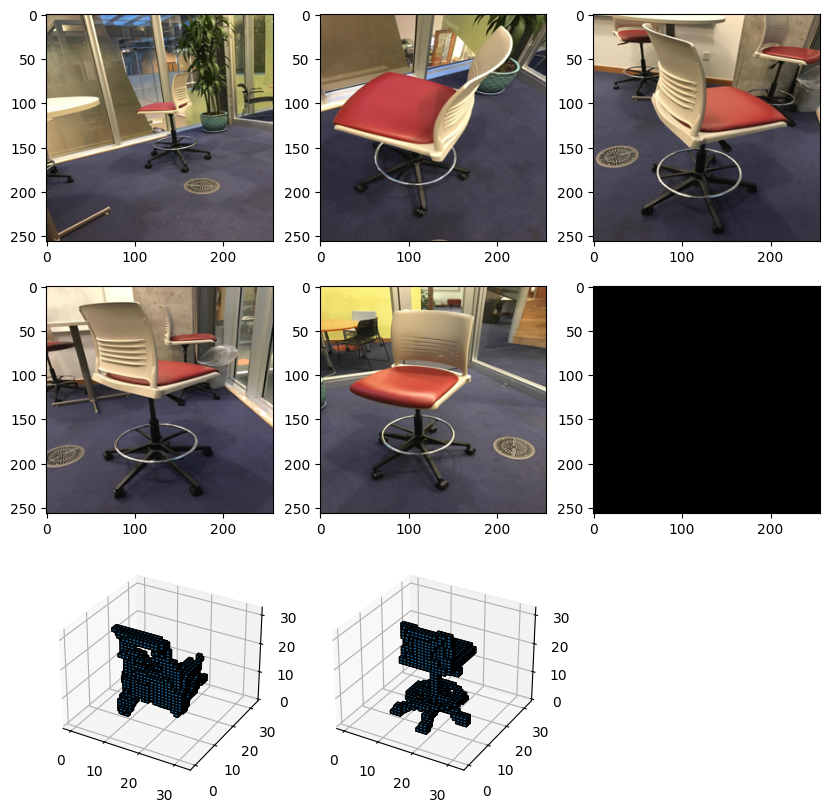

In [ ]:
# Change this variable to any positive integer to look through the test set
k = 0

n = 6
fig =  plt.figure(figsize=(10, 10))
for i in range(n):
    ax = fig.add_subplot(4, 3, i + 1)
    plt.imshow(X_test[k][i])

ax = fig.add_subplot(4, 3, 2*3 + 1, projection='3d')
ax.voxels(test_pred_tresholded[k,:,:,:], edgecolor='k')

ax = fig.add_subplot(4, 3, 3*3 + 1, projection='3d')
ax.voxels(y_test[k,:,:,:], edgecolor='k')

plt.show()